# **Two-Dimensional Pure Diffusion - MARK III - Gauss-Seidel With Successive Over-Relaxation (SOR)**

---



## Import Libraries

In [ ]:
import numpy as np
import math
import time
!pip install memory_profiler
from memory_profiler import memory_usage

## Problem Data

In [ ]:

# Computational Domain
L = 2
H = 1

ncx = 20
ncy = 10
ncell = ncx * ncy

omega_otimo = 2 / (1 + np.sin(np.pi / ncx))
print(f"Omega ótimo ≈ {omega_otimo:.4f}")

dx = L/ncx
dy = H/ncy

# Cell Center
def cellCenter(i):
  xcell=dx/2+(i%ncx)*dx
  ycell=dy/2+int(i/ncx)*dy
  return xcell,ycell

# k(x,y) Equation

k_ref = 0.15
k_x = 1
k_y = 0

def k_xy(k_ref,k_x,k_y,x,y):
  return k_ref * (k_x * np.cos(np.pi*(2*x/L)) + k_y * np.sin(np.pi * (y/H)))

# Source Term

def Fonte(k_ref,k_x,k_y,x,y):
  return (400*k_ref*k_x*np.pi**2*np.sin((2*np.pi*x)/L)*np.sin((2*np.pi*y)/H + (4*np.pi*x)/L))/L**2 - (800*k_ref*np.pi**2*np.cos((2*np.pi*y)/H + (4*np.pi*x)/L)*(k_x*np.cos((2*np.pi*x)/L) + k_y*np.sin((np.pi*y)/H)))/L**2 - (100*k_ref*k_y*np.pi**2*np.cos((np.pi*y)/H)*np.sin((2*np.pi*y)/H + (4*np.pi*x)/L))/H**2 - (200*k_ref*np.pi**2*np.cos((2*np.pi*y)/H + (4*np.pi*x)/L)*(k_x*np.cos((2*np.pi*x)/L) + k_y*np.sin((np.pi*y)/H)))/H**2

# Partial Derivatives dT_dx e dT_dy

def dT_dx(x,y,L,H):
  return -(200*np.pi*np.sin((2*np.pi*y)/H + (4*np.pi*x)/L))/L
def dT_dy(x,y,L,H):
  return -(100*np.pi*np.sin((2*np.pi*y)/H + (4*np.pi*x)/L))/H





Omega ótimo ≈ 1.9806


## Analytical Solution

In [ ]:


# Analytical Solution Function, T(x,y)

def T_analitica(x,y):
  return 50 * np.cos((np.pi*4*x/L) + (np.pi*2*y/H)) + 200


## Numerical Resolution and Errors

In [ ]:
import numpy as np
from numpy import linalg as LA

#initialize arrays
A = np.zeros((ncell,ncell))
PHI = np.zeros(ncell)
AW = np.zeros(ncell)
AE = np.zeros(ncell)
AN = np.zeros(ncell)
AS = np.zeros(ncell)
SU = np.zeros(ncell)
SP = np.zeros(ncell)
Error_abs = np.zeros(ncell)
Error_rel = np.zeros(ncell)

#Set method coefficients
for i in range(0, ncell):

    xcell,ycell=cellCenter(i)
    Termo_fonte = - Fonte(k_ref,k_x,k_y,xcell,ycell)
    FI_dT_dx = dT_dx(xcell+dx/2,ycell,L,H)
    FI_dT_dy = dT_dy(xcell,ycell+dy/2,L,H)
    TI_0Y = T_analitica(xcell -dx/2,ycell)
    TI_X0 = T_analitica(xcell,ycell-dy/2)

    k_w = k_xy(k_ref,k_x,k_y,xcell-dx/2,ycell)
    k_e = k_xy(k_ref,k_x,k_y,xcell+dx/2,ycell)
    k_n = k_xy(k_ref,k_x,k_y,xcell,ycell+dy/2)
    k_s = k_xy(k_ref,k_x,k_y,xcell,ycell-dy/2)

    AW[i]=k_w * dy/dx
    AE[i]=k_e * dy/dx
    AS[i]=k_s * dx/dy
    AN[i]=k_n * dx/dy
    SU[i]=Termo_fonte * dx * dy
    SP[i]=0

    if i<ncx: ## First Row, South Boundary, Imposed Temperature, Dirichlet Condition
        AS[i] = 0
        SU[i] += 2 * k_s * TI_X0 * dx/dy
        SP[i] += -2 * k_s * dx/dy

    if i % ncx == 0 : ## First Column, West Boundary, Imposed Temperature, Dirichlet Condition
        AW[i] = 0
        SU[i] += 2 * k_w * TI_0Y * dy/dx
        SP[i] += -2 * k_w * dy/dx

    if (i+1) % ncx == 0 : ## Last column, East Boundary, Imposed Flux, Neumann Condition
        AE[i] = 0
        SU[i] += k_e * FI_dT_dx * dy
        SP[i] += 0

    if i >= (ncell-ncx): ## Last Row, North Boundary, Imposed Flux, Neumann Condition
        AN[i] = 0
        SU[i] += k_n * FI_dT_dy * dx
        SP[i] += 0

# Implementation of the Gauss-Seidel SOR Method

def gauss_seidel_sor(PHI, AW, AE, AN, AS, SP, SU, ncx, ncy, omega=1.96, max_iter=60000, tol=1e-8):
    ncell = ncx * ncy
    for it in range(max_iter):
        PHI_old = PHI.copy()
        for i in range(ncell):
            ap = AW[i] + AE[i] + AN[i] + AS[i] - SP[i]
            phi_w = PHI[i - 1] if i % ncx != 0 else 0
            phi_e = PHI[i + 1] if (i + 1) % ncx != 0 else 0
            phi_s = PHI[i - ncx] if i >= ncx else 0
            phi_n = PHI[i + ncx] if i < ncell - ncx else 0

            phi_gs = (AW[i] * phi_w + AE[i] * phi_e + AS[i] * phi_s + AN[i] * phi_n + SU[i]) / ap
            PHI[i] = (1 - omega) * PHI[i] + omega * phi_gs

        # Convergence Critterion
        error = np.linalg.norm(PHI - PHI_old) / np.linalg.norm(PHI)
        if error < tol:
            print(f"SOR convergiu em {it+1} iterações com erro = {error:.2e}")
            break
    else:
        print("SOR não convergiu no número máximo de iterações.")
    return PHI

#Numerical Resolution with SOR and Time Count
def run_sor():
    PHI = np.zeros(ncell)
    PHI = gauss_seidel_sor(PHI, AW, AE, AN, AS, SP, SU, ncx, ncy, omega=1.7, tol=1e-8)
    return PHI

start_time = time.time()
mem_usage, PHI = memory_usage(run_sor, retval=True, max_usage=True)
end_time = time.time()

print(f"Tempo de execução: {end_time - start_time:.4f} segundos")
print(f"Memória máxima usada: {mem_usage:.2f} MB")

# Calculate the errors
for i in range(0, ncell):
   xcell,ycell = cellCenter(i)
   Error_abs[i] = abs((PHI[i]-T_analitica(xcell,ycell)))
   Error_rel[i] = abs((PHI[i]-T_analitica(xcell,ycell))/T_analitica(xcell,ycell))

print("Average Absolute Error:",LA.norm(Error_abs)/ncell)
print("Average Relative Error:",LA.norm(Error_rel)/ncell)

SOR convergiu em 36157 iterações com erro = 1.00e-08
Tempo de execução: 8475.6295 segundos
Memória máxima usada: 710.11 MB
Average Absolute Error: 5.8641478795118166e-05
Average Relative Error: 3.450619202849723e-07


## Analytical Solution for all Cells

In [ ]:
#Create new variable to store the Analytical solution
PHI_ana = np.zeros(ncell)

# Calculate Analytical solution values
for i in range(0, ncell):
    xcell,ycell = cellCenter(i)
    PHI_ana[i]=T_analitica(xcell,ycell)



## Plot the Graph

In [ ]:
def vec2Grid(var, nx, ny):
    z = np.zeros((ny, nx))  # (rows, columns)
    for i in range(len(var)):
        z[int(i / nx), i % nx] = var[i]
    return z

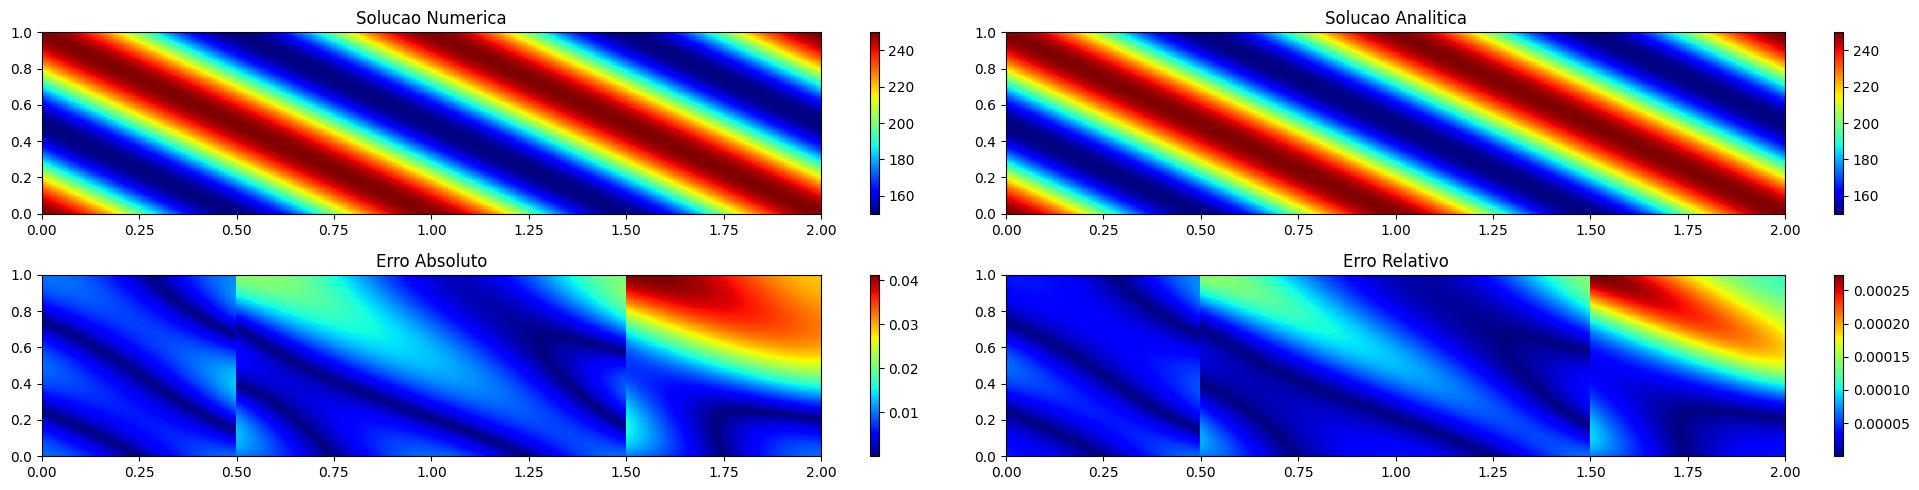

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

y, x = np.mgrid[slice(0, H + dy, dy),
                slice(0, L + dx, dx)]

#print(x
#print(y)
figScl=10
fig, axs = plt.subplots(2, 2,figsize=(figScl*L/H,figScl*H/L))

ax = axs[0, 0]
z = vec2Grid(PHI,ncx,ncy)
#print(z)
Var_min, Var_max = np.abs(PHI).min(), np.abs(PHI).max()
c = ax.pcolor(x, y, z, cmap='jet', vmin=Var_min, vmax=Var_max)
ax.set_title('Solucao Numerica')
fig.colorbar(c, ax=ax)

ax = axs[0, 1]
z = vec2Grid(PHI_ana,ncx,ncy)
#print(z)
Var_min, Var_max = np.abs(PHI_ana).min(), np.abs(PHI_ana).max()
c = ax.pcolor(x, y, z, cmap='jet', vmin=Var_min, vmax=Var_max)
ax.set_title('Solucao Analitica')
fig.colorbar(c, ax=ax)

ax = axs[1, 0]
z = vec2Grid(Error_abs,ncx,ncy)
Var_min, Var_max = np.abs(Error_abs).min(), np.abs(Error_abs).max()
c = ax.pcolor(x, y, z, cmap='jet', vmin=Var_min, vmax=Var_max)
ax.set_title('Erro Absoluto')
fig.colorbar(c, ax=ax)

ax = axs[1, 1]
z = vec2Grid(Error_rel,ncx,ncy)
Var_min, Var_max = np.abs(Error_rel).min(), np.abs(Error_rel).max()
c = ax.pcolor(x, y, z, cmap='jet', vmin=Var_min, vmax=Var_max)
ax.set_title('Erro Relativo')
fig.colorbar(c, ax=ax)

fig.tight_layout()

plt.show()

